In [255]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import BPTTRNN as bp
import time
# import sklearn.svm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create synthetic data
There are 8 possible values: 
- 0 $blank/0$
- 1 $A_1$
- 2 $A_2$
- 3 $B_1$
- 4 $B_2$
- 5 $C_1$
- 6 $C_2$
- 7 $D$

Data points are thus 8-dim vectors, with:

$z_{k, t} = (1_{0}, 1_{A_1}, 1_{A_2}, ... , 1_{D})$

where $k$ is the trial index, and $t$ is the trial time. Hence $|z_{k, t}| = 1 $ before white noise is added. Trials will be $T=9$ data points long, and of form:

$ 0, A_{\alpha}, 0, B_{\alpha}, 0, C_{\beta}, 0, D, 0 $

where $\alpha, \beta \in (1, 2)$, although I must use shorter sequences for testing (e.g. $0, A_{\alpha}, 0, B_{\alpha}, 0$).

Network input $x_k = z_{k, 0:T-1}$ and output $y_k = z_{k, 1:T}$. 

In [77]:
n_total = 100  # total number of data sequences
n_freq = 3  # blank through D
n_times = 5

ratio_train = 0.8
ratio_exp, ratio_unexp = 0.5, 0.5  # probabilities of switching between alpha nd beta
noise_scale = 0.05

n_train = int(ratio_train * n_total)
n_test = n_total - n_train
ratio_control = 0
ratio_exp, ratio_unexp = ratio_exp / (ratio_exp + ratio_unexp + ratio_control),  ratio_unexp / (ratio_exp + ratio_unexp + ratio_control)
assert ratio_exp + ratio_unexp + ratio_control == 1

## simple data generation for now:
all_seq = np.zeros((n_total, n_times, n_freq))
all_seq[:, 0, 0] = 1
all_seq[:, 1, 1] = 1
all_seq[:, 2, 0] = 1
all_seq[:, 3, 2] = 1
all_seq[:, 4, 0] = 1

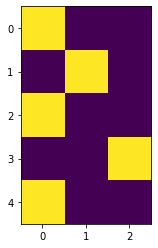

In [78]:
plt.imshow(all_seq.mean(0))

In [80]:
## Train/test data:

shuffle_ind = np.random.choice(a=n_total, size=n_total, replace=False)
all_seq = all_seq[shuffle_ind, :, :]  # shuffle randomly, (TODO: Stratified split)
train_seq = all_seq[:n_train, :, :]
test_seq = all_seq[n_train:, :, :]
x_train = train_seq[:, :-1, :] + (np.random.randn(n_train, n_times - 1, n_freq) * noise_scale)
y_train = train_seq[:, 1:, :]
x_test = test_seq[:, :-1, :] + (np.random.randn(n_test, n_times - 1, n_freq) * noise_scale)
y_test = test_seq[:, 1:, :]
x_train, y_train, x_test, y_test = map(
    torch.tensor, (x_train, y_train, x_test, y_test))
x_train, y_train, x_test, y_test = x_train.float(), y_train.float(), x_test.float(), y_test.float()

## RNN Model with BPTT

#### RNN model:

$(x_t, s_{t-1}) \to s_t \to \hat{y}_t == y_t = x_{t+1} $

within one trial $k$. 
Equations:

$s_t = \tanh( U \cdot x_t + W \cdot s_{t-1})$


$\hat{y}_t = softmax(V \cdot s_t) = \left( \frac{e^{V_i \cdot s_t}}{\sum_i e^{V_i \cdot s_t}} \right), \; for \; i \in (0, A_1, A_2 ... D)$

where $U_{n x f}, W_{n x n}, V_{f x n}$ are matrices where $n$ is the number of RNN nodes and $f$ the number of input/output frequencies.

#### Training procedure:

The full sequence $x_k$ is forwarded through the model, yielding $\hat{y}_k$. This is used to compute the loss function $L$, which error is backpropagated through time (BPTT) to the parameters $U, W, V$ (updated with SGD probably). 
The loss function $L$ uses cross entropy:

$L_k = \sum_{\tau} - y_{k, \tau} \log \hat{y}_{k, \tau}$ + regularisation?

where $\tau$ defines the trial times that are taken into account for Loss computation. 

$ \begin{equation}
    \tau =
    \begin{cases}
      (0, 1, 2, ... 8), & \text{all} \\
      (1, 3, 5, 7), & \text{non-blank (nb)}\\
      (3, 5, 7), & \text{non-initial nb (ninb)}
    \end{cases}
  \end{equation}$

#### Initial conditions:

Tricky.. Maybe start on each trials with either zero, or small-magnitude noise, for $s_{k, -1}$? The sequence $0, A_{\alpha}, 0$ then should provide a sensible initialisation, needed for $B_{\alpha}$ prediction... ?  


#### Pseudo-algorithm:

    for $it$ in epochs:
        for $k$ in trials:
            for $t$ in times:
                rnn.forward($x_t$)
            compute loss $L_k$
            update parameters with BPTT


In [157]:
n_nodes = 20
learning_rate = 0.1
bs = 1
n_epochs = 100
check_conv = False
conv_rel_tol = 1e-6
l1_param = 1e-4

In [243]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs)

In [264]:
rnn = bp.RNN(n_stim=n_freq, n_nodes=n_nodes)
opt = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
prev_loss = 10

In [270]:
print('Initialising traing')
print('Train performance:')

loss_list = []
for epoch in range(n_epochs):
    rnn.train()
    for xb, yb in train_dl:  # returns torch(n_bs x n_times x n_freq)
        full_pred = bp.compute_full_pred(model=rnn, xdata=xb, ydata=yb)
        loss = bp.tau_loss(y_est=full_pred, y_true=yb, model=rnn, reg_param=l1_param)
        loss_list.append(float(loss.detach().numpy()))
        loss.backward()  # compute gradients
        opt.step()  # update 
        opt.zero_grad()  # reset
        
    rnn.eval()
    if epoch % 10 == 1:
        print(f'epoch {epoch},  loss: {bp.tau_loss(y_est=full_pred, y_true=yb, model=rnn)}')
        
#     if check_conv:
#         new_loss = loss_function(pred, yb).detach().numpy()
#         diff = np.abs(new_loss - prev_loss) / (new_loss + prev_loss)
#         if diff < conv_rel_tol:
#             print(f'Converged at epoch {epoch},  loss: {loss_function(pred, yb)}')
#             break
#         prev_loss = new_loss
rnn.eval()
# with torch.no_grad():
#     print('Test performance:')
#     for xb, yb in test_dl:
#         test_pred = bp.compute_full_pred(xdata=xb, ydata=yb, model=rnn)
#         print(bp.tau_loss(y_est=test_pred, y_true=y_test, model=rnn, reg_param=l1_param))    

Initialising traing
Train performance:
epoch 1,  loss: 0.06037118285894394
epoch 11,  loss: 0.05953645706176758
epoch 21,  loss: 0.05870130658149719
epoch 31,  loss: 0.0579422190785408
epoch 41,  loss: 0.05715874582529068
epoch 51,  loss: 0.05644970387220383
epoch 61,  loss: 0.05577225238084793
epoch 71,  loss: 0.0551016591489315
epoch 81,  loss: 0.054503027349710464
epoch 91,  loss: 0.053896404802799225


RNN(
  (lin_input): Linear(in_features=3, out_features=20, bias=True)
  (lin_feedback): Linear(in_features=20, out_features=20, bias=True)
  (lin_output): Linear(in_features=20, out_features=3, bias=True)
)

In [277]:
bp.tau_loss(y_est=full_pred, y_true=yb, model=rnn)

tensor(0.0535, grad_fn=<AddBackward0>)

In [274]:
test_pred = bp.compute_full_pred(xdata=x_test, ydata=y_test, model=rnn)
bp.tau_loss(y_est=test_pred, y_true=y_test, model=rnn, reg_param=l1_param)

shape xdata: torch.Size([20, 4, 3])
n samples: 20


tensor(0.0056, grad_fn=<AddBackward0>)

In [276]:
with torch.no_grad():
    print('Test performance:')
    for xb, yb in train_dl:
        test_pred = bp.compute_full_pred(xdata=xb, ydata=yb, model=rnn)
        print(bp.tau_loss(y_est=test_pred, y_true=yb, model=rnn, reg_param=l1_param))    

Test performance:
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0057)
tensor(0.0056)
tensor(0.0055)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0057)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0055)
tensor(0.0056)
tensor(0.0056)
tensor(0.0057)
tensor(0.0056)
tensor(0.0055)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0057)
tensor(0.0056)
tensor(0.0057)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0057)
tensor(0.0056)
tensor(0.0057)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0057)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0057)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0057)
tensor(0.0056)
tensor(0.0057)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(0.0056)
tensor(

In [ ]:
print(bp.tau_loss(y_est=test_pred, y_true=y_test, model=rnn, reg_param=l1_param))    